In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, plot_roc_curve, roc_auc_score, recall_score,
    precision_score, f1_score, classification_report, RocCurveDisplay)
from sklearn.model_selection import train_test_split


ny_df = pd.read_csv('./data/NY/newyork.csv')

In [2]:
ny_df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status
0,2008,UNKNOWN,MALE,55,Not Returned
1,2008,ALBANY,MALE,16,Returned Parole Violation
2,2008,ALBANY,MALE,17,Not Returned
3,2008,ALBANY,MALE,17,Returned Parole Violation
4,2008,ALBANY,MALE,18,Not Returned


In [3]:
ny_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188650 entries, 0 to 188649
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Release Year          188650 non-null  int64 
 1   County of Indictment  188650 non-null  object
 2   Gender                188650 non-null  object
 3   Age at Release        188650 non-null  int64 
 4   Return Status         188650 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.2+ MB


In [4]:
ny_df.isnull().sum()

Release Year            0
County of Indictment    0
Gender                  0
Age at Release          0
Return Status           0
dtype: int64

In [5]:
ny_df.describe()

,Release Year,Age at Release
count,188650.000000,188650.000000
mean,2011.326064,35.473400
std,2.289170,10.972873
min,2008.000000,16.000000
25%,2009.000000,26.000000
50%,2011.000000,34.000000
75%,2013.000000,44.000000
max,2015.000000,100.000000


In [6]:
ny_df['Return Status'].value_counts()

Not Returned                 110003
Returned Parole Violation     61381
New Felony Offense            17266
Name: Return Status, dtype: int64

In [7]:
ny_df['Gender'].value_counts(normalize = True)

MALE      0.937228
FEMALE    0.062772
Name: Gender, dtype: float64

In [8]:
#maybe potential here to make this an ordinal target variable like Gabe was interested in however given the categories not sure how insightful it would be.
ny_df['recidivism'] = ny_df['Return Status'].map({'Not Returned': 0, 'Returned Parole Violation' : 1, 'New Felony Offense' : 1})

In [9]:
ny_df['gender_map'] = ny_df['Gender'].map({'MALE': 1, 'FEMALE': 0})
ny_df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status,recidivism,gender_map
0,2008,UNKNOWN,MALE,55,Not Returned,0,1
1,2008,ALBANY,MALE,16,Returned Parole Violation,1,1
2,2008,ALBANY,MALE,17,Not Returned,0,1
3,2008,ALBANY,MALE,17,Returned Parole Violation,1,1
4,2008,ALBANY,MALE,18,Not Returned,0,1


In [10]:
ny_df['recidivism'].value_counts()

0    110003
1     78647
Name: recidivism, dtype: int64

In [11]:
#break out male and female into two different datasets and explore variation in relationship between features and target across genders

In [12]:
reinc = ny_df[ny_df['recidivism'] == 1]
reinc.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status,recidivism,gender_map
1,2008,ALBANY,MALE,16,Returned Parole Violation,1,1
3,2008,ALBANY,MALE,17,Returned Parole Violation,1,1
5,2008,ALBANY,MALE,18,Returned Parole Violation,1,1
6,2008,ALBANY,MALE,18,Returned Parole Violation,1,1
7,2008,ALBANY,MALE,18,Returned Parole Violation,1,1


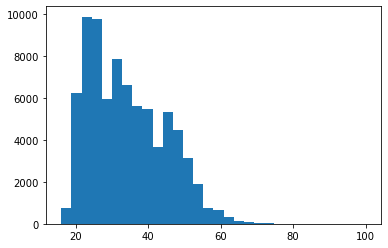

In [13]:
plt.hist(ny_df[ny_df['recidivism'] == 1]['Age at Release'], bins = 30);

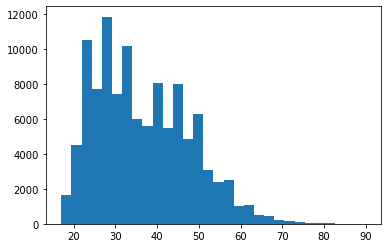

In [14]:
plt.hist(ny_df[ny_df['recidivism'] == 0]['Age at Release'], bins = 30);

In [15]:
#split the dataset into different age ranges below 30, 30-50, 50 and above
below30 = ny_df[ny_df['Age at Release'] < 30]
between_30_50 = ny_df[(ny_df['Age at Release'] >= 30) & (ny_df['Age at Release'] <= 50)]
above50 = ny_df[ny_df['Age at Release'] > 50]

In [16]:
#calculate recidivism rate for each age group
#recidivism = reincarcerated / total pop

below30_recid_rate = (below30[below30['recidivism'] == 1]['recidivism'].value_counts()) / below30.shape[0]
between_30_50_recid_rate = (between_30_50[between_30_50['recidivism'] == 1]['recidivism'].value_counts()) / between_30_50.shape[0]
above_50_recid_rate = (above50[above50['recidivism'] == 1]['recidivism'].value_counts()) / above50.shape[0]

In [17]:
print(f' Recidivism Rate Below 30: {below30_recid_rate}')
print(f' Recidivism Rate Between 30 and 50: {between_30_50_recid_rate}')
print(f' Recidivism Rate Above 50: {above_50_recid_rate}')

 Recidivism Rate Below 30: 1    0.473064
Name: recidivism, dtype: float64
 Recidivism Rate Between 30 and 50: 1    0.400774
Name: recidivism, dtype: float64
 Recidivism Rate Above 50: 1    0.301231
Name: recidivism, dtype: float64


In [18]:
male = ny_df[ny_df['Gender'] == 'MALE']
female = ny_df[ny_df['Gender'] == 'FEMALE']

In [19]:
female.shape

(11842, 7)

In [20]:
male.shape

(176808, 7)

### Modeling

Classification Models
1. Logistic Regression
2. KNN
3. Random Forest
4. Ada and XGBoost
5. Stacked Model


In [28]:
#Logistic Regression

X = ny_df[['gender_map', 'Age at Release']]
y = ny_df['recidivism']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [29]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [31]:
lr.score(X_train, y_train)

0.5868312989885996

In [32]:
lr.score(X_test, y_test)

0.5877276678752412